<a href="https://colab.research.google.com/github/BigBubl1k/Background_deleter/blob/main/%D0%A3%D0%B4%D0%B0%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%84%D0%BE%D0%BD%D0%B0_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A2%D1%8E%D1%80%D0%B8%D0%BD_%D0%98%D0%B3%D0%BE%D1%80%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Решать задачу будем через сегментацию: обучим нейронку сегментации изображений, и классическими методами уберем фон, оставив только основной класс на изображении

## Подключение бибилиотек


In [ ]:
# Основа для модели нейронной сети
from tensorflow.keras.models import Model 

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Дополнительные утилиты keras
from tensorflow.keras import utils 

# Инструменты для построения графиков
import matplotlib.pyplot as plt 

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Инструменты для работы с массивами
import numpy as np 

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image 

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

## Загрузка датасета

Подготовим нужные данные для обучения сети для базы с самолетами размером 456х256

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/airplane_456x256.zip', None, quiet=True)

'airplane_456x256.zip'

In [ ]:
# Распаковка архива

!unzip -qo airplane_456x256.zip

In [ ]:
# Глобальные параметры

IMG_WIDTH = 200               # Ширина картинки 
IMG_HEIGHT = 400              # Высота картинки 
CLASS_COUNT = 2               # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
#функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 1.14 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.04 с
Количество изображений: 50


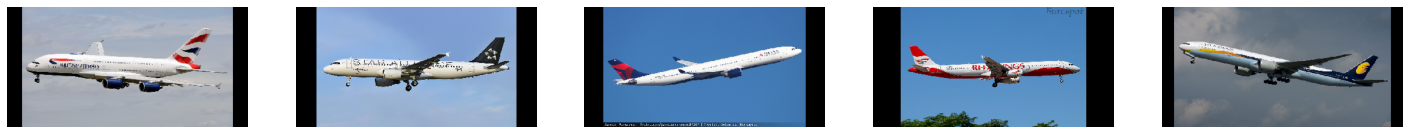

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 2.40 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.12 с
Количество изображений: 50


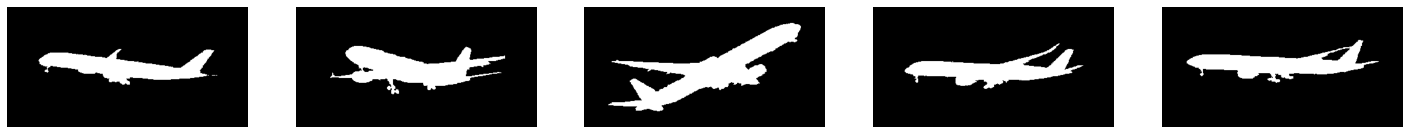

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Цвета пикселей сегментированных изображений

AIRPLANE = (255, 255, 255)      # Самолет (белый)
BACKGROUND = (0, 0, 0)          # Фон (черный)

In [ ]:
CLASS_LABELS = (AIRPLANE, BACKGROUND)

## Создание выборки

Переведем сегментированные изображения в одноканальные сегментированные с номером класса в каждом пикселе

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

Обратная функция, перевод одноканальных сегментированных изображений с номером класса в каждом пикселе в 3х канальное RGB сегментированное изображение:

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

Сформируем выборки:

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(931, 200, 400, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(50, 200, 400, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(931, 200, 400, 1)
(50, 200, 400, 1)


## Простая линейная (последовательная) архитектура

Для начала попробуем простую линейную модель:

In [ ]:
def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model 

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(CLASS_COUNT,
                                       (IMG_WIDTH, IMG_HEIGHT, 3))

model_seq.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 400, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 200, 400, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 200, 400, 128)     0         
                                                                 
 block1_conv3 (Conv2D)       (None, 200, 400, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 200, 400, 64)     256       
 hNormalization)                                             

In [ ]:
# Обучение модели

history = model_seq.fit(x_train, y_train,
                        epochs=50, batch_size=32,
                        validation_data=(x_val, y_val))

Epoch 1/50
30/30 [==============================] - 56s 1s/step - loss: 0.7525 - sparse_categorical_accuracy: 0.5677 - val_loss: 0.6110 - val_sparse_categorical_accuracy: 0.8835
Epoch 2/50
30/30 [==============================] - 41s 1s/step - loss: 0.5752 - sparse_categorical_accuracy: 0.8563 - val_loss: 0.5866 - val_sparse_categorical_accuracy: 0.9123
Epoch 3/50
30/30 [==============================] - 41s 1s/step - loss: 0.4808 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.5498 - val_sparse_categorical_accuracy: 0.9283
Epoch 4/50
30/30 [==============================] - 41s 1s/step - loss: 0.4074 - sparse_categorical_accuracy: 0.9318 - val_loss: 0.5016 - val_sparse_categorical_accuracy: 0.9314
Epoch 5/50
30/30 [==============================] - 41s 1s/step - loss: 0.3480 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.4209 - val_sparse_categorical_accuracy: 0.9382
Epoch 6/50
30/30 [==============================] - 41s 1s/step - loss: 0.2989 - sparse_categorical_accuracy: 

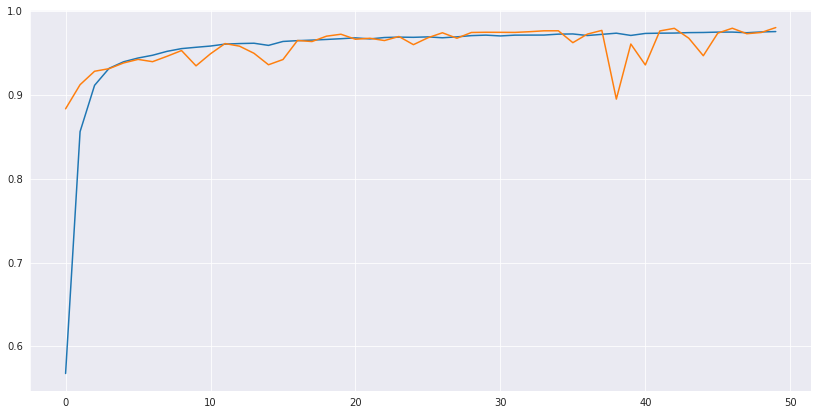

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
model_seq.save_weights('model_seq.h5')

In [ ]:
model_seq = sequential_segmentation_net(CLASS_COUNT,
                                       (IMG_WIDTH, IMG_HEIGHT, 3))
model_seq.load_weights('model_seq.h5')


Теперь посмотрим на результат работы модели:

In [ ]:
#функция перевода карты признаков в RGB формат
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 255, 255]  # самолет
    return color 

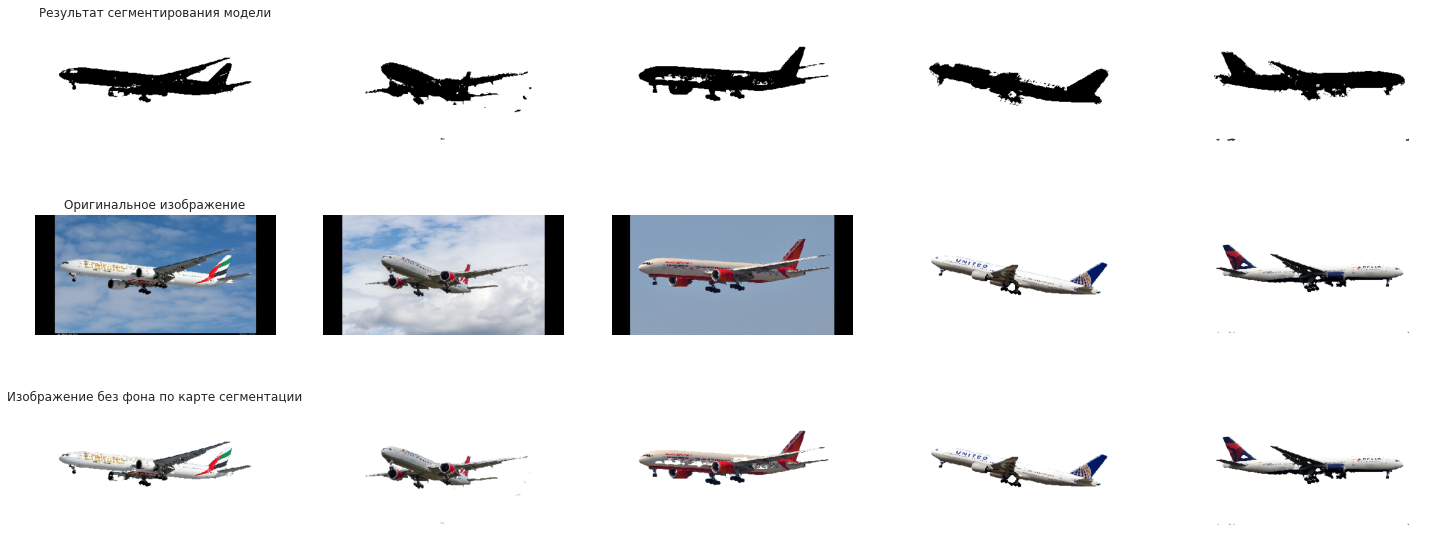

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(3, count, figsize=(25, 10)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model_seq.predict(x_val[idx].reshape(1, IMG_WIDTH, IMG_HEIGHT, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(IMG_WIDTH, IMG_HEIGHT,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта

    axs[0, 0].set_title('Результат сегментирования модели')
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')

    axs[1, 0].set_title('Оригинальное изображение')
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение  
    axs[1,i].axis('off')

    axs[2, 0].set_title('Изображение без фона по карте сегментации')

    x_val[idx][pr1[:,:,0] > 10] = [255, 255, 255]       #по маске избавляемся от фона изображения
    axs[2,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение   
    axs[2,i].axis('off') 
plt.show() 

Выводы: нам удалось достичь довольно хорошего результата

Улучшить его можно, используя архитектуру Unet или PSP-net, применить мне их не удалось из-за исчерпания лимита пользования коллабом

Так же хочется отметить, что наша база обучалась всего лишь на 931 изображении

Использовав простую аугментацию (поворачивая, приближая в разных точках изображение и его карту сегментации), мы могли бы получить огрмоную базу, достаточную для очень крепких результатов